In [1]:
import pandas as pd
import torch
import numpy as np

# LRAP. Instance-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LRAP(preds, labels):
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = (scores.sum(-1) / labels.sum(-1)).mean()
    return score.item()

# label-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LWLRAP(preds, labels):
    preds = preds.to('cpu')
    labels = labels.to('cpu')

    labels[labels > 0.0] = 1.0  # label smoothingする場合もスコア計算のため1にしてしまう
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    # Number of GT labels per instance
    # num_labels = labels.sum(-1)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = scores.sum() / labels.sum()
    return score.item()

In [2]:

input_dir = "../oof/"
oof = pd.read_csv(input_dir + "fold0_oof.csv")
# oof1 = pd.read_csv(input_dir + "fold1_oof.csv")
# oof2 = pd.read_csv(input_dir + "fold2_oof.csv")
# oof3 = pd.read_csv(input_dir + "fold3_oof.csv")
# oof4 = pd.read_csv(input_dir + "fold4_oof.csv")
# oof = pd.concat([oof0, oof1, oof2, oof3, oof4])
oof

,patch,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,0,00834f88e,0.373827,0.441171,0.429482,0.867053,0.409134,0.472102,0.435524,0.415645,...,0.442382,0.360218,0.362298,0.373247,0.798004,0.382377,0.399084,0.388208,0.398772,0.439408
1,1,00834f88e,0.421995,0.408670,0.416480,0.867339,0.394195,0.502639,0.431045,0.402370,...,0.406092,0.377287,0.385323,0.370773,0.689050,0.394015,0.407089,0.387633,0.422403,0.427796
2,2,00834f88e,0.410289,0.411962,0.422318,0.847634,0.396981,0.511860,0.432790,0.383964,...,0.423601,0.334544,0.373144,0.372081,0.794763,0.385481,0.394683,0.388364,0.442054,0.431300
3,3,00834f88e,0.447076,0.401724,0.429355,0.840568,0.400162,0.552543,0.429956,0.392252,...,0.400193,0.376226,0.414650,0.368168,0.663203,0.405769,0.408310,0.402587,0.435706,0.404675
4,4,00834f88e,0.435928,0.433058,0.430536,0.818535,0.416066,0.555609,0.441142,0.408392,...,0.424945,0.387385,0.412394,0.392753,0.718288,0.413439,0.412153,0.402446,0.438271,0.418102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7555,3,ff7f876bd,0.372156,0.402773,0.430044,0.819664,0.402917,0.434716,0.455124,0.479302,...,0.431583,0.364503,0.364031,0.388520,0.920196,0.417982,0.396471,0.426125,0.404158,0.432781
7556,4,ff7f876bd,0.363173,0.401165,0.413729,0.836556,0.389371,0.431401,0.450193,0.479371,...,0.455311,0.365588,0.358468,0.376203,0.907199,0.409524,0.394094,0.418454,0.409613,0.430314
7557,5,ff7f876bd,0.349484,0.408229,0.410039,0.818109,0.399281,0.432983,0.453413,0.475606,...,0.472404,0.384030,0.360518,0.406326,0.909069,0.411204,0.389992,0.422811,0.387396,0.436284
7558,6,ff7f876bd,0.352583,0.391860,0.398356,0.821509,0.393557,0.427424,0.450309,0.488756,...,0.492653,0.392095,0.355686,0.381522,0.901653,0.408487,0.390919,0.427719,0.379317,0.431623


In [3]:
oof2 = oof.groupby('recording_id').max().reset_index(drop=False)
oof2

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,00834f88e,7,0.447076,0.441171,0.430536,0.869495,0.416066,0.555609,0.444031,0.416361,...,0.442382,0.420489,0.414650,0.394128,0.834913,0.413439,0.412153,0.402587,0.442054,0.447433
1,008c9c381,7,0.383405,0.425855,0.422817,0.847453,0.416249,0.462420,0.424034,0.415482,...,0.386822,0.346964,0.451283,0.427177,0.479083,0.420265,0.443152,0.436672,0.325355,0.458838
2,00b404881,7,0.457658,0.683583,0.411737,0.522533,0.472279,0.426853,0.411925,0.447021,...,0.397360,0.493022,0.424349,0.440522,0.428826,0.410598,0.441342,0.954733,0.352460,0.434758
3,016240b9a,7,0.465996,0.466204,0.453727,0.541098,0.398612,0.452411,0.436857,0.796326,...,0.476840,0.460637,0.463811,0.457967,0.514584,0.447766,0.446519,0.428659,0.892067,0.449527
4,0201197ec,7,0.436750,0.452039,0.444664,0.539586,0.428883,0.451046,0.443825,0.487557,...,0.484501,0.438181,0.451359,0.453430,0.493917,0.460186,0.454725,0.464221,0.361302,0.449332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,fed5d1b9c,7,0.426298,0.435337,0.435393,0.753673,0.388594,0.446893,0.447995,0.462989,...,0.466818,0.884958,0.455009,0.721538,0.527045,0.445703,0.444197,0.433300,0.384709,0.444886
941,ff21001e6,7,0.469361,0.458458,0.465558,0.495746,0.398131,0.454231,0.441620,0.455911,...,0.458736,0.479534,0.772766,0.861122,0.483351,0.455442,0.643508,0.476961,0.383519,0.449168
942,ff22519ea,7,0.392210,0.453849,0.445089,0.498739,0.298126,0.433404,0.461345,0.918595,...,0.448448,0.878184,0.440573,0.423910,0.453643,0.452699,0.434945,0.419965,0.328728,0.465119
943,ff5c2d55f,7,0.384649,0.435181,0.415816,0.894334,0.409117,0.436287,0.452206,0.463865,...,0.447712,0.429667,0.411992,0.374894,0.875059,0.424601,0.397694,0.450199,0.424182,0.447077


In [9]:
tp = pd.read_csv("../input/rfcx-species-audio-detection/train_tp.csv")
tp_fnames, tp_labels = [], []
for recording_id, df in tp.groupby("recording_id"):
    v = sum([np.eye(24)[i] for i in df["species_id"].tolist()])
    v = (v >= 1).astype(int).tolist()
    tp_fnames.append(recording_id)
    tp_labels.append(v) 

tp2 = pd.DataFrame(tp_labels, columns=[f's{i}' for i in range(24)])
tp2['recording_id'] = tp_fnames
tp2 = tp2.sort_values('recording_id')
tp2


,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s15,s16,s17,s18,s19,s20,s21,s22,s23,recording_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,003bec244
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,006ab765f
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,007f87ba2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0099c367b
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,009b760e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fe8d9ac40
1128,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fea6b438a
1129,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ff2eb9ce5
1130,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ffb8d8391


In [10]:
tp_oof = oof2[oof2['recording_id'].isin(tp2['recording_id'])].reset_index(drop=True).sort_values('recording_id')
tp_oof

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,00b404881,7,0.457658,0.683583,0.411737,0.522533,0.472279,0.426853,0.411925,0.447021,...,0.397360,0.493022,0.424349,0.440522,0.428826,0.410598,0.441342,0.954733,0.352460,0.434758
1,0201197ec,7,0.436750,0.452039,0.444664,0.539586,0.428883,0.451046,0.443825,0.487557,...,0.484501,0.438181,0.451359,0.453430,0.493917,0.460186,0.454725,0.464221,0.361302,0.449332
2,04e70a8e3,7,0.384868,0.428216,0.437783,0.487168,0.276911,0.429094,0.547141,0.759387,...,0.454329,0.637617,0.440533,0.424034,0.448813,0.450262,0.452378,0.396687,0.310519,0.521028
3,0509303a5,7,0.481310,0.413362,0.440338,0.514970,0.445257,0.436803,0.924495,0.889518,...,0.487941,0.454207,0.442137,0.442218,0.485693,0.444976,0.449095,0.401669,0.476821,0.425618
4,055088446,7,0.456453,0.463032,0.449060,0.612704,0.502720,0.446806,0.438804,0.458646,...,0.943255,0.457056,0.445069,0.459323,0.497114,0.467191,0.447296,0.966671,0.370602,0.459652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,f7d92975f,7,0.429196,0.471915,0.440813,0.520241,0.406832,0.453295,0.439822,0.477745,...,0.687799,0.440545,0.428323,0.434869,0.724554,0.461154,0.472691,0.439316,0.464412,0.888835
222,f84b8c8d3,7,0.466143,0.470952,0.449599,0.571259,0.425192,0.454513,0.440441,0.461123,...,0.462036,0.440402,0.446379,0.449042,0.497262,0.462361,0.450832,0.438249,0.363498,0.876409
223,f851b9605,7,0.451419,0.462992,0.456116,0.545601,0.453647,0.456228,0.565943,0.479422,...,0.482771,0.446998,0.447589,0.460380,0.492869,0.459714,0.454553,0.462523,0.326789,0.445374
224,f8c661973,7,0.551693,0.460263,0.443456,0.599430,0.406221,0.450899,0.439017,0.521386,...,0.450684,0.445378,0.933707,0.456061,0.478099,0.454060,0.475847,0.436708,0.412809,0.458287


In [11]:
tp2 = tp2[tp2["recording_id"].isin(tp_oof["recording_id"])]

In [12]:
pred = tp_oof.loc[:, 's0':'s23'].values
target = tp2.loc[:, 's0':'s23'].values

In [13]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
auc = roc_auc_score(target, pred, average=None)
auc

array([0.9875    , 0.98888889, 0.99545455, 0.79351852, 0.95      ,
       0.99398148, 0.99283154, 0.93611111, 0.98287037, 0.9969697 ,
       0.98425926, 0.96388889, 0.9837963 , 0.99305556, 0.99490741,
       0.96620584, 0.99897593, 0.99259259, 0.96064815, 0.99942661,
       0.99598624, 0.96296296, 0.99539171, 0.99718548])

<BarContainer object of 24 artists>

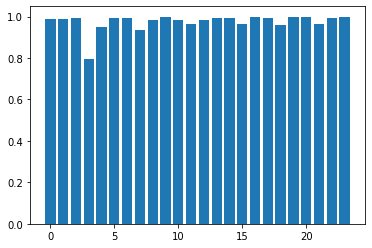

In [14]:
plt.bar(np.arange(24), auc)

In [15]:
pred = torch.tensor(pred)
target = torch.tensor(target)
pred.shape, target.shape

(torch.Size([226, 24]), torch.Size([226, 24]))

In [16]:
original_lwlrap = LWLRAP(pred, target)
original_lwlrap

0.7920806407928467